### Description:
This is the model that Jacob implemented in file model_03_qrc_esn_v2_7. 
1. I added two grid search nets, one that moddifies the data structure generated by the Mackey-Glass function and the second one that that optimizes the hyperparameters of the RC.
2. I tested 4 different Mackey-Glass generation sets: 
3. Technical aspect: I added a new library (joblib) that lets you use all the cores of your CPU for the grid search process (which is parallel)


### Observations:
1. For every M-G data the best output based on MSE was for the following hp: \
leakage_rate                         0.99 \
window_size                             6 \
n_layers                                3 
2. At first the code was running very slowly but the multi core solution works much better (on my machine). 
3. The model works perfectly for one-step-ahead prediction for the different tested M-G data sets. 

### Future improvements:
1. Now I want to test the same M-G data but now not to use one-step-ahead prediction but rather use an autonomous prediction. (All will remain the same but the prediciton of the model will be made on his previous predictions and not on real results)
2. I will test all the things to this point but for the ARMA data set that Sebastian used in his model.

### My ideas to improve the model:
1. The current QRC model on the output only measures the individual states of the respective qubits but does not use the correlations between them, maybe we could implement that. That would increase the dimentionality of output data. (Kornjačy, Fujii and Nakajima used this methodology)
2. Test the model on autonomus data predictions for the whole test period.

In [26]:
# !pip install joblib

In [27]:
# === Krok 1: Import niezbędnych bibliotek ===
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
from tqdm.notebook import tqdm  # Do wizualizacji postępu pętli
# NOWOŚĆ: Import biblioteki joblib
from joblib import Parallel, delayed

print("Biblioteki zaimportowane.")

Biblioteki zaimportowane.


In [28]:
# === Krok 2: Przygotowanie danych (funkcje z oryginalnego notebooka) ===

def mackey_glass(beta=0.17, gamma=0.1, n=10, tau=30, dt=1.5, T=2000):
    """
    Symuluje szereg czasowy Mackey-Glass.
    Zwraca wartości przeskalowane do przedziału [0, 1].
    """
    N = int(T / dt)
    delay_steps = int(tau / dt)
    x = np.zeros(N + delay_steps)
    x[0:delay_steps] = 1.2

    for t in range(delay_steps - 1, N + delay_steps - 1):
        x_tau = x[t - delay_steps]
        dxdt = beta * x_tau / (1 + x_tau**n) - gamma * x[t]
        x[t+1] = x[t] + dxdt * dt

    x_min, x_max = np.min(x), np.max(x)
    x_scaled = (x - x_min) / (x_max - x_min)
    return x_scaled[delay_steps:]

# Zmodyfikowana funkcja, która przyjmuje dodatkowy parametr 'lag'
def create_io_pairs(data, window_size, lag=0):
    """
    Tworzy pary wejście-wyjście, uwzględniając opóźnienie (lag).
    
    Args:
        data (np.array): Szereg czasowy.
        window_size (int): Długość okna wejściowego.
        lag (int): Przesunięcie okna w przeszłość. 
                   lag=0 -> okno kończy się na t-1.
                   lag=2 -> okno kończy się na t-3.
    """
    inputs = []
    outputs = []
    # Pętla musi uwzględnić całkowitą długość (okno + opóźnienie)
    for i in range(len(data) - window_size - lag):
        # Wejście: okno `window_size` punktów
        input_window = data[i : i + window_size]
        inputs.append(input_window)
        
        # Wyjście: JEDEN punkt po oknie ORAZ po opóźnieniu
        output_point = data[i + window_size + lag]
        outputs.append(output_point)
        
    return np.array(inputs), np.array(outputs)



In [29]:
# === Krok 3: Definicja modelu QRC-ESN (funkcje z oryginalnego notebooka) ===

# Definicja urządzenia kwantowego - będzie tworzone dynamicznie w pętli
# w zależności od liczby kubitów (window_size)
def get_q_device(n_qubits, seed):
    return qml.device("default.qubit", wires=n_qubits, seed=seed)

def quantum_feature_map(inputs, weights, biases, n_layers, n_qubits, dev):
    """
    Obwód kwantowy działający jako mapa cech.
    """
    @qml.qnode(dev)
    def circuit(inputs, weights, biases):
        for i in range(n_qubits):
            total_angle = inputs[i] + biases[i]
            qml.RX(total_angle, wires=i)

        for layer in range(n_layers):
            for i in range(n_qubits):
                qml.Rot(*weights[layer, i], wires=i)
            for i in range(n_qubits - 1):
                qml.CNOT(wires=[i, i+1])
        
        return [qml.expval(qml.PauliX(i)) for i in range(n_qubits)] + \
               [qml.expval(qml.PauliY(i)) for i in range(n_qubits)] + \
               [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]
               
    return circuit(inputs, weights, biases)

def train_esn_reservoir(train_inputs, train_outputs, n_layers, n_qubits, leakage_rate, lambda_reg, seed):
    """
    Trenuje kwantowy rezerwuar z wykorzystaniem klasycznego ESN do obsługi pamięci.
    """
    np.random.seed(seed)
    weights = np.random.uniform(-np.pi, np.pi, (n_layers, n_qubits, 3))
    biases = np.random.uniform(-0.5, 0.5, n_qubits)
    
    n_observables = 3 * n_qubits
    n_samples = len(train_inputs)
    
    dev = get_q_device(n_qubits, seed)

    # 1. Obliczanie klasycznych stanów ESN
    classical_states = np.zeros((n_samples, n_qubits))
    current_classical_state = np.zeros(n_qubits)
    for t in range(n_samples):
        current_classical_state = (1 - leakage_rate) * current_classical_state + leakage_rate * train_inputs[t]
        classical_states[t] = current_classical_state
        
    # 2. Mapowanie stanów klasycznych na cechy kwantowe
    quantum_features = np.zeros((n_samples, n_observables))
    for t in range(n_samples):
        quantum_features[t] = quantum_feature_map(
            inputs=classical_states[t], weights=weights, biases=biases,
            n_layers=n_layers, n_qubits=n_qubits, dev=dev
        )
        
    # 3. Trening warstwy odczytu (Ridge Regression)
    R = quantum_features
    Y = train_outputs.reshape(-1, 1)
    I = np.identity(n_observables)
    W_out = np.linalg.solve(R.T @ R + lambda_reg * I, R.T @ Y).flatten()
    
    return W_out, weights, biases

def predict_esn(test_inputs, weights, biases, W_out, n_layers, n_qubits, leakage_rate, seed):
    """
    Dokonuje predykcji na podstawie wytrenowanego modelu.
    """
    predictions = []
    current_classical_state = np.zeros(n_qubits)
    dev = get_q_device(n_qubits, seed)

    for input_val in test_inputs:
        current_classical_state = (1 - leakage_rate) * current_classical_state + leakage_rate * input_val
        
        q_features = quantum_feature_map(
            inputs=current_classical_state, weights=weights, biases=biases,
            n_layers=n_layers, n_qubits=n_qubits, dev=dev
        )
        
        y_pred = np.dot(W_out, q_features)
        predictions.append(y_pred)
        
    return np.array(predictions)




In [30]:
def run_single_experiment(params, profile, time_series, train_fraction, seed):
    """
    Uruchamia pojedynczy eksperyment dla danej kombinacji hiperparametrów
    i danego profilu danych. Zwraca słownik z wynikami.
    """
    leakage, lambda_r, win_size, layers, lag = params
    
    current_params = {
        'data_profile': profile['name'],
        'leakage_rate': leakage,
        'lambda_reg': lambda_r,
        'window_size': win_size,
        'n_layers': layers,
        'lag': lag
    }
    
    # Przygotowanie danych
    n_qubits = win_size
    train_size = int(len(time_series) * train_fraction)
    train_inputs, train_outputs = create_io_pairs(time_series[:train_size], win_size)
    test_inputs, test_outputs = create_io_pairs(time_series[train_size:], win_size)
    
    if len(test_inputs) == 0:
        current_params['mse'] = float('nan') # Zwróć NaN, jeśli nie da się przetestować
        return current_params

    # Trening
    W_out, weights, biases = train_esn_reservoir(
        train_inputs, train_outputs, layers, n_qubits, leakage, lambda_r, seed)
    
    # Predykcja
    test_preds = predict_esn(
        test_inputs, weights, biases, W_out, layers, n_qubits, leakage, seed)
    
    # Obliczenie błędu i zwrot wyników
    mse = np.mean((test_preds - test_outputs)**2)
    current_params['mse'] = mse
    
    return current_params

In [31]:
# === Krok 4: Definicja profili danych i siatki hiperparametrów ===

# Definicja profili danych na podstawie raportu
data_profiles = [
    # {
    #     'name': 'Okresowy (tau=15)',
    #     'params': {'beta': 2, 'gamma': 1, 'n': 9.65, 'tau': 2, 'dt': 0.1, 'T': 2000}
    # },
    {
        'name': 'Klasyczny Chaos (tau=17)',
        'params': {'beta': 0.2, 'gamma': 0.1, 'n': 10, 'tau': 17, 'dt': 1.0, 'T': 2000}
    },
    {
        'name': 'Złożony Chaos (tau=30)',
        'params': {'beta': 0.2, 'gamma': 0.1, 'n': 10, 'tau': 30, 'dt': 1.0, 'T': 2000}
    },
    {
        'name': 'Hiperchaotyczny (tau=100)',
        'params': {'beta': 0.2, 'gamma': 0.1, 'n': 10, 'tau': 100, 'dt': 1.0, 'T': 2000}
    }
]

# Siatka hiperparametrów do przetestowania
param_grid = {
    'leakage_rate': [0.1, 0.5, 0.99],
    'lambda_reg': [1e-8],
    'window_size': [4, 5, 6, 7],
    'n_layers': [1, 2, 3, 4],
    'lag': [0]
}

# Stałe parametry symulacji
all_results = []
train_fraction = 0.7 # Procent danych na zbiór treningowy
seed = 2025

In [32]:
# === Krok 5: Główna pętla badawcza ===

for profile in data_profiles:
    print(f"\n{'='*60}")
    print(f"Rozpoczynam testy dla profilu danych: {profile['name']}")
    print(f"{'='*60}")

    time_series = mackey_glass(**profile['params'])
    param_combinations = list(itertools.product(*param_grid.values()))

    # NOWOŚĆ: Wywołanie zrównoleglone
    # n_jobs=-1 oznacza "użyj wszystkich dostępnych rdzeni"
    # 'backend="multiprocessing"' jest domyślny, ale warto go znać
    # tqdm jest zintegrowane z joblib, wystarczy użyć with
    with tqdm(total=len(param_combinations), desc=f"Processing {profile['name']}") as pbar:
        profile_results = Parallel(n_jobs=-1)(
            delayed(run_single_experiment)(params, profile, time_series, train_fraction, seed)
            for params in param_combinations
        )
    
    all_results.extend(profile_results)



Rozpoczynam testy dla profilu danych: Klasyczny Chaos (tau=17)


Processing Klasyczny Chaos (tau=17):   0%|          | 0/48 [00:00<?, ?it/s]


Rozpoczynam testy dla profilu danych: Złożony Chaos (tau=30)


Processing Złożony Chaos (tau=30):   0%|          | 0/48 [00:00<?, ?it/s]


Rozpoczynam testy dla profilu danych: Hiperchaotyczny (tau=100)


Processing Hiperchaotyczny (tau=100):   0%|          | 0/48 [00:00<?, ?it/s]

In [33]:
# === Krok 6: Analiza i zapis wyników ===

results_df = pd.DataFrame(all_results)
results_df_sorted = results_df.sort_values(by='mse', ascending=True)

# Zapis do pliku CSV
nazwa_pliku = 'results_full_analysis.csv'
results_df_sorted.to_csv(nazwa_pliku, index=False)

print(f"\n\n{'='*60}")
print("--- ZAKOŃCZONO WSZYSTKIE EKSPERYMENTY ---")
print(f"Wyniki zostały pomyślnie zapisane do pliku '{nazwa_pliku}'.")
print(f"{'='*60}")

# Wyświetlenie najlepszych wyników dla każdego profilu danych
print("\nNajlepsze znalezione kombinacje parametrów dla każdego typu danych:")
best_results_per_profile = results_df.loc[results_df.groupby('data_profile')['mse'].idxmin()]
print(best_results_per_profile.to_string())

print("\n\nPełna tabela wszystkich wyników (posortowana od najlepszych globalnie):")
print(results_df_sorted.to_string())



--- ZAKOŃCZONO WSZYSTKIE EKSPERYMENTY ---
Wyniki zostały pomyślnie zapisane do pliku 'results_full_analysis.csv'.

Najlepsze znalezione kombinacje parametrów dla każdego typu danych:
                  data_profile  leakage_rate    lambda_reg  window_size  n_layers  lag                     mse
138  Hiperchaotyczny (tau=100)          0.99  1.000000e-08            6         3    0  1.7534989493554395e-06
42    Klasyczny Chaos (tau=17)          0.99  1.000000e-08            6         3    0  1.6209553331002016e-06
90      Złożony Chaos (tau=30)          0.99  1.000000e-08            6         3    0  1.3939124730679538e-06


Pełna tabela wszystkich wyników (posortowana od najlepszych globalnie):
                  data_profile  leakage_rate    lambda_reg  window_size  n_layers  lag                     mse
90      Złożony Chaos (tau=30)          0.99  1.000000e-08            6         3    0  1.3939124730679538e-06
42    Klasyczny Chaos (tau=17)          0.99  1.000000e-08            6    

Przygotowuję wykresy dla najlepszych konfiguracji dla każdego z profili danych...

--- Generowanie wykresu dla: Hiperchaotyczny (tau=100) ---
Najlepsze parametry:
data_profile    Hiperchaotyczny (tau=100)
leakage_rate                         0.99
lambda_reg                            0.0
window_size                             6
n_layers                                3
lag                                     0
mse                1.7534989493554395e-06


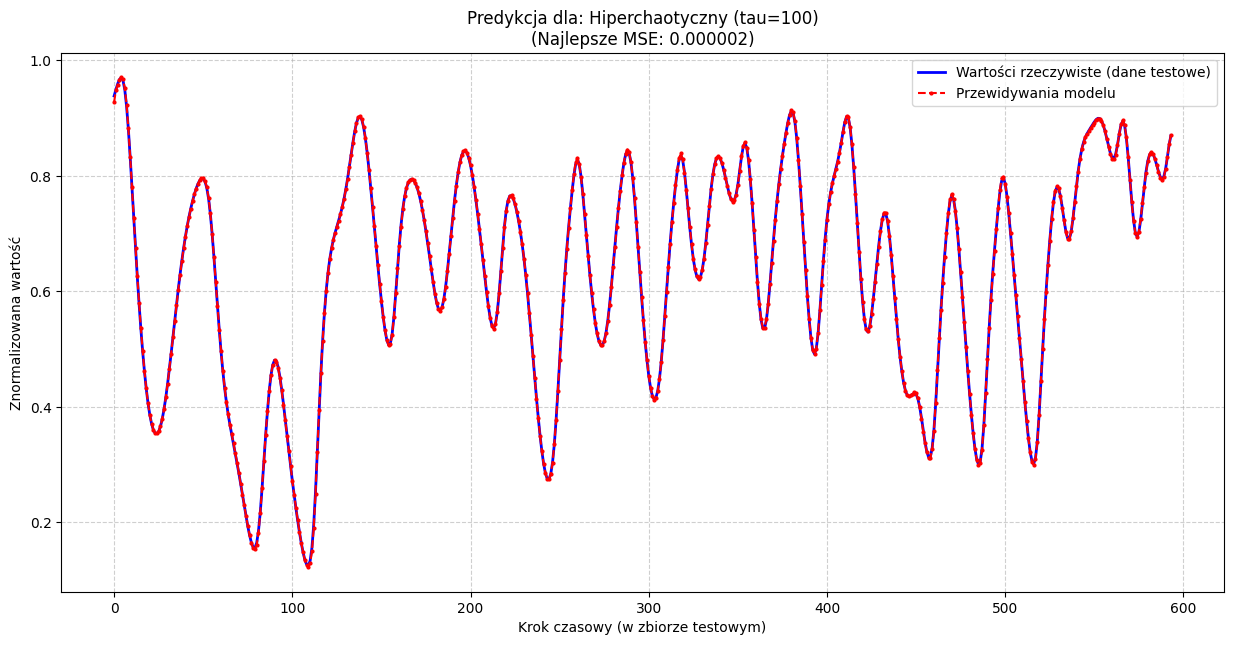


--- Generowanie wykresu dla: Klasyczny Chaos (tau=17) ---
Najlepsze parametry:
data_profile    Klasyczny Chaos (tau=17)
leakage_rate                        0.99
lambda_reg                           0.0
window_size                            6
n_layers                               3
lag                                    0
mse               1.6209553331002016e-06


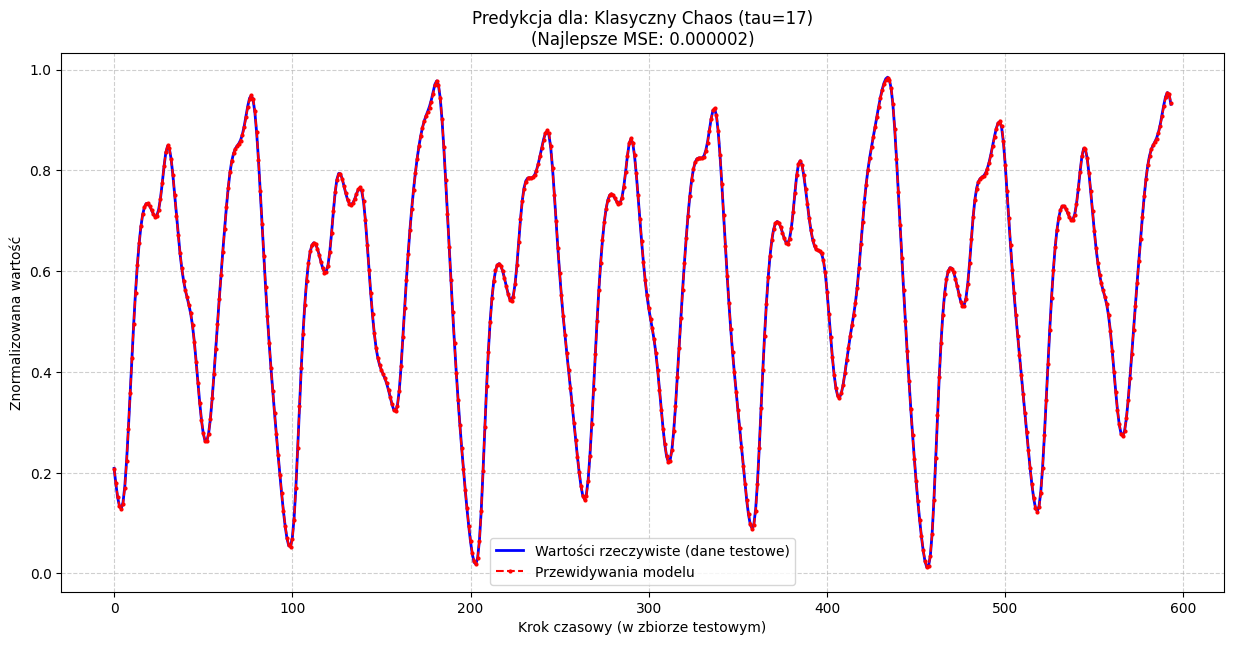


--- Generowanie wykresu dla: Złożony Chaos (tau=30) ---
Najlepsze parametry:
data_profile    Złożony Chaos (tau=30)
leakage_rate                      0.99
lambda_reg                         0.0
window_size                          6
n_layers                             3
lag                                  0
mse             1.3939124730679538e-06


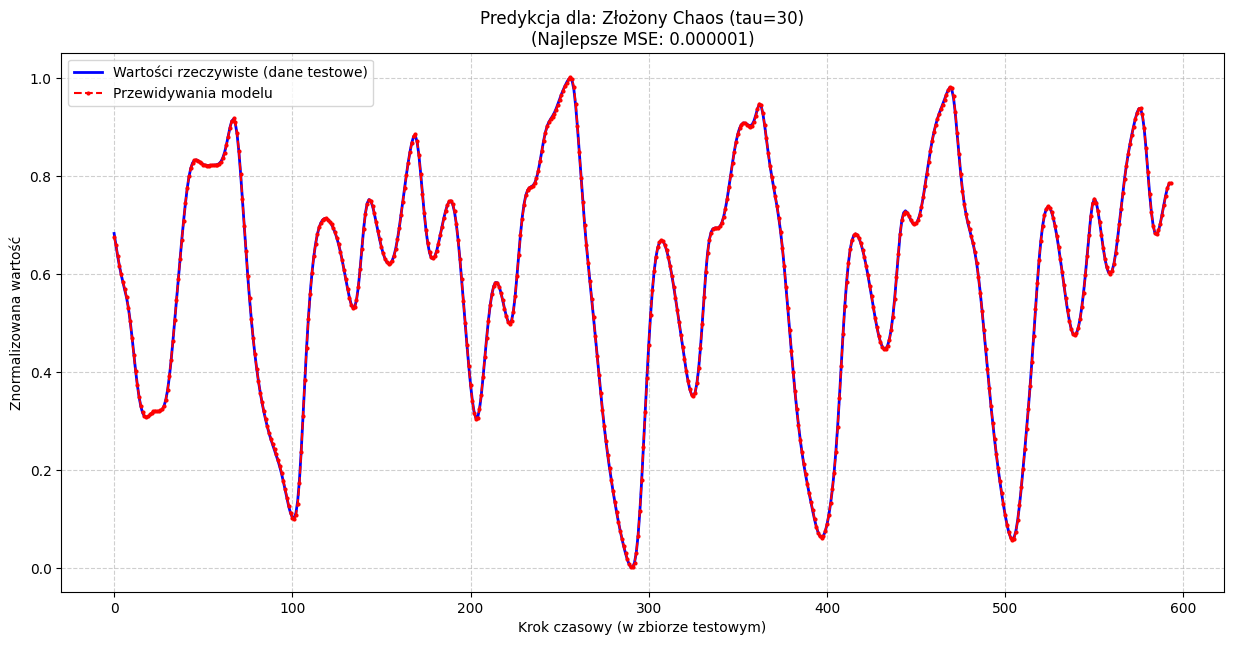

In [34]:
# === Krok 7: Wizualizacja wyników dla najlepszej konfiguracji dla KAŻDEGO zbioru danych ===

print("Przygotowuję wykresy dla najlepszych konfiguracji dla każdego z profili danych...")

# Sprawdzenie, czy są jakieś wyniki
if not results_df.empty:
    # 1. Znajdź najlepsze parametry dla każdego profilu danych
    best_results_per_profile = results_df.loc[results_df.groupby('data_profile')['mse'].idxmin()]
    
    # 2. Stwórz pętlę, która przejdzie przez każdy z tych najlepszych wyników
    for index, best_params_row in best_results_per_profile.iterrows():
        
        best_params_dict = best_params_row.to_dict()
        profile_name = best_params_dict['data_profile']
        
        print(f"\n--- Generowanie wykresu dla: {profile_name} ---")
        print(f"Najlepsze parametry:\n{best_params_row.to_string()}")

        # 3. Wygeneruj ponownie odpowiedni szereg czasowy
        profile_gen_params = next((p['params'] for p in data_profiles if p['name'] == profile_name))
        time_series_for_best_model = mackey_glass(**profile_gen_params)

        # 4. Przygotuj dane treningowe i testowe
        best_win_size = int(best_params_dict['window_size'])
        best_n_qubits = best_win_size
        train_size_best = int(len(time_series_for_best_model) * train_fraction)
        
        train_inputs, train_outputs = create_io_pairs(time_series_for_best_model[:train_size_best], best_win_size)
        test_inputs, test_outputs = create_io_pairs(time_series_for_best_model[train_size_best:], best_win_size)

        # 5. Wytrenuj najlepszy model i dokonaj predykcji
        W_out, weights, biases = train_esn_reservoir(
            train_inputs, train_outputs,
            n_layers=int(best_params_dict['n_layers']),
            n_qubits=best_n_qubits,
            leakage_rate=best_params_dict['leakage_rate'],
            lambda_reg=best_params_dict['lambda_reg'],
            seed=seed
        )

        best_test_preds = predict_esn(
            test_inputs, weights, biases, W_out,
            n_layers=int(best_params_dict['n_layers']),
            n_qubits=best_n_qubits,
            leakage_rate=best_params_dict['leakage_rate'],
            seed=seed
        )

        # 6. Stwórz dedykowany wykres dla tego profilu danych
        plt.figure(figsize=(15, 7))
        plt.plot(test_outputs, label="Wartości rzeczywiste (dane testowe)", color="blue", linewidth=2)
        plt.plot(best_test_preds, label="Przewidywania modelu", color="red", linestyle="--", marker='.', markersize=4)
        
        plt.xlabel("Krok czasowy (w zbiorze testowym)")
        plt.ylabel("Znormalizowana wartość")
        plt.title(f"Predykcja dla: {profile_name}\n(Najlepsze MSE: {best_params_dict['mse']:.6f})")
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()

else:
    print("Brak wyników do zwizualizowania. Uruchom najpierw Grid Search.")